# Comparative Analysis of Predictive Performance

# config and imports


In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Pfad zum Projekt-Root hinzufügen, um das Package 'src' zu finden
# Annahme: Dieses Notebook liegt in src/notebooks/
import sys
from pathlib import Path

import joblib
import pandas as pd
from tqdm import tqdm

In [2]:
# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.d_eval.evaluation.loader import load_test_data_v2, load_model
from src.d_eval.evaluation.style import apply_shap_style
import src.b_feature_eng
sys.modules['src.features'] = sys.modules["src.b_feature_eng"]

apply_shap_style()


In [3]:
# paths
DATA_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/features/asinh1-reg"
VAL_SET_PATH = DATA_DIR + "/splits/val_purged.parquet"
SCALER_PATH = DATA_DIR + "/scaler/scaler.joblib"
MODELS_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/models"
TABPF_PRED_FILE = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/predictions/distributed/TABPFN_100k_77f_FULL_PREDS.parquet"

# target
TARGET_COL = "label_5min"
THINNING_FREQ_MIN = 5

# data
TTD_MINUTES_MIN = 0
TTD_MINUTES_MAX = 300

# models
MODEL_PATHS = {
    "CatBoost": MODELS_DIR + "/" + "CatBoostGPU.joblib",
    "MLP": MODELS_DIR + "/" + "MLP.joblib",
    "RF": MODELS_DIR + "/" + "RandomForest.joblib",
    "EBM": MODELS_DIR + "/" + "ebm.joblib",
    "LASSO": MODELS_DIR + "/" + "Lasso_LargeScale.joblib",
}

# load data & models


## init scaler and models

In [4]:
# init scaler
scaler = joblib.load(SCALER_PATH)
ttd_col_name = scaler.ttd_col  # Meistens 'te_min_to_delivery'
print("Scaler geladen.")
print(f"TTD-Spaltenname im Scaler: {ttd_col_name}")

# load models
models = {}
for model_name, model_path in tqdm(MODEL_PATHS.items(), desc="Modelle laden"):
    model = load_model(model_path)
    models[model_name] = model

Scaler geladen.
TTD-Spaltenname im Scaler: time_to_delivery_min


Modelle laden:  20%|██        | 1/5 [00:00<00:01,  3.54it/s]/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Fixing missing 'multi_class' attribute for MLPRegressor...


/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Modelle laden:  60%|██████    | 3/5 [00:00<00:00,  4.35it/s]/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentV

## load data and rescale

In [5]:
# load data
X_test_scaled, y_test_scaled = load_test_data_v2(
    VAL_SET_PATH,
    target_col=TARGET_COL,
    keep_id_cols=True,
    sample_minutes=THINNING_FREQ_MIN,
    min_ttd_minutes=TTD_MINUTES_MIN,
    max_ttd_minutes=TTD_MINUTES_MAX,
)

# extract product keys for later use
product_keys = X_test_scaled['delivery_start']
snapshot_times = X_test_scaled['snapshot_times']
ttd_min = (product_keys - snapshot_times).dt.total_seconds() / 60

# drop id cols from features
X_test_scaled = X_test_scaled.drop(columns=['delivery_start', "snapshot_times"])

print("-" * 30)
print(f"Anzahl Test-Samples (nach Downsampling): {len(y_test_scaled):,}")

# retransform true values
df_temp = pd.DataFrame({
    TARGET_COL: y_test_scaled,
    ttd_col_name: ttd_min
}, index=X_test_scaled.index)
df_inv = scaler.inverse_transform(df_temp)
y_test_raw = df_inv[TARGET_COL].values

#  retransform featuers
X_test_scaled[scaler.ttd_col] = ttd_min

X_test_raw = scaler.inverse_transform(X_test_scaled)
del X_test_scaled[scaler.ttd_col]

Memory usage of dataframe is 1496.47 MB
Memory usage after optimization is: 1450.66 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 4,002,956 auf 142,153 Zeilen reduziert.
Clipping TTD window to range: 0 - 300 minutes
Rows to be clipped based on TTD min: 0 / 142153 (0.00%)
Rows to be clipped based on TTD max: 0 / 142153 (0.00%)
Data shape after clipping TTD window: (142153, 80)
------------------------------
Anzahl Test-Samples (nach Downsampling): 142,153


Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 758.01it/s]


## generate predictions and rescale

In [6]:
# generate predictions and inverse transform
preds_scaled = {}
preds_raw = {}

for model_name, model in tqdm(models.items(), desc="Modelle laden und Vorhersagen generieren"):
    # predict
    y_pred_scaled = model.predict(X_test_scaled)
    preds_scaled[model_name] = y_pred_scaled

    # Inverse transform der Vorhersagen
    df_temp = pd.DataFrame({
        TARGET_COL: y_pred_scaled,
        ttd_col_name: ttd_min
    }, index=X_test_scaled.index)
    df_inv = scaler.inverse_transform(df_temp)
    preds_raw[model_name] = df_inv[TARGET_COL].values


Modelle laden und Vorhersagen generieren: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


## load tabpfn and rescale

In [7]:
import pandas as pd
import numpy as np

if TABPF_PRED_FILE:
    # --- 1. DEINE EXISTIERENDEN LISTEN (Die "Wahrheit") ---

    # Wir bauen daraus ein "Skelett"-DataFrame, das die exakte Reihenfolge vorgibt
    df_skeleton = pd.DataFrame({
        'delivery_start': product_keys,
        'snapshot_times': snapshot_times
    })

    # WICHTIG: Sicherstellen, dass es Datetime-Objekte sind (für sauberen Merge)
    df_skeleton['delivery_start'] = pd.to_datetime(df_skeleton['delivery_start'])
    df_skeleton['snapshot_times'] = pd.to_datetime(df_skeleton['snapshot_times'])

    # --- 2. TABPFN PREDICTIONS LADEN ---
    # Das File aus dem Merge-Script
    df_tabpfn = pd.read_parquet(TABPF_PRED_FILE)

    # Auch hier Datentypen erzwingen
    df_tabpfn['delivery_start'] = pd.to_datetime(df_tabpfn['delivery_start'])
    df_tabpfn['snapshot_times'] = pd.to_datetime(df_tabpfn['snapshot_times'])

    # Vor dem Merge: Duplikate in den Predictions entfernen!
    # Falls Jobs doppelt liefen, könnte ein Zeitstempel 2x in df_tabpfn sein.
    # Wir behalten den letzten (oder ersten), um den Merge nicht aufzublähen.
    df_tabpfn = df_tabpfn.drop_duplicates(subset=['delivery_start', 'snapshot_times'], keep='last')

    # --- 3. DER ALIGNMENT MERGE (Left Join) ---
    # "how='left'" bedeutet: Behalte ALLE Zeilen aus df_skeleton in genau DER Reihenfolge.
    # Suche passenden Eintrag in df_tabpfn. Wenn keiner da ist -> NaN.
    df_aligned = pd.merge(
        df_skeleton,
        df_tabpfn[['delivery_start', 'snapshot_times', 'y_pred']],  # Nur relevante Spalten
        on=['delivery_start', 'snapshot_times'],
        how='left'
    )

    # --- 4. CHECK & EXTRAKTION ---

    # A) Plausibilitäts-Check
    print(f"Länge Original-Liste: {len(df_skeleton)}")
    print(f"Länge Aligned-Liste:  {len(df_aligned)}")  # Muss identisch sein!

    # B) Auf fehlende Predictions prüfen (Löcher im Schweizer Käse?)
    missing_mask = df_aligned['y_pred'].isna()
    n_missing = missing_mask.sum()

    assert n_missing == 0, f"⚠ ACHTUNG: {n_missing} Predictions fehlen (Matching nicht erfolgreich)!"

    # C) Das finale Numpy Array für deine Metriken
    y_pred_tabpfn_scaled = df_aligned['y_pred'].values

    # --- 5. reverse scaling ---
    df_temp = pd.DataFrame({
        TARGET_COL: y_pred_tabpfn_scaled,
        ttd_col_name: ttd_min
    }, index=X_test_scaled.index)

    df_inv = scaler.inverse_transform(df_temp)
    y_pred_tabpfn_raw = df_inv[TARGET_COL].values

Länge Original-Liste: 142153
Länge Aligned-Liste:  142153


Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 21893.94it/s]


In [8]:
preds_raw_with_tabpfn = preds_raw.copy()
preds_scaled_with_tabpfn = preds_scaled.copy()

if "y_pred_tabpfn_raw" in globals() and "y_pred_tabpfn_scaled" in globals():
    preds_raw_with_tabpfn["TabPFN"] = y_pred_tabpfn_raw
    preds_scaled_with_tabpfn["TabPFN"] = y_pred_tabpfn_scaled

# performance comparison

In [9]:
from src.d_eval.evaluation.predictive_performance import calc_statistical_metrics_split

df_err, df_qual = calc_statistical_metrics_split(preds_scaled_with_tabpfn, y_test_scaled, preds_raw_with_tabpfn,
                                                 y_test_raw, snapshot_times, baseline_model_name="LASSO")
display(df_err)
display(df_qual)

Significance Testing: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s]


,MAE[S],MAE[€],RMSE[S],RMSE[€],rMAE
Model,,,,,
CatBoost,0.8524†,3.7388†,1.0929†,31.4131†,0.9983†
RF,0.8530***,3.7413***,1.0936*,31.4174*,0.9990***
LASSO,0.8539***,3.7452***,1.0945***,31.4158*,1.0000***
EBM,0.8545***,3.7455***,1.0956***,31.4156,1.0001***
MLP,0.8543***,3.7458***,1.0948***,31.4153,1.0002***
TabPFN,0.9870***,4.2074***,1.3148***,31.6656,1.1234***


,R2[S],R2[€],HitRatio,Bias[€]
Model,,,,
CatBoost,0.0071†,0.0005†,52.75%†,0.0387†
RF,0.0059*,0.0002*,52.58%**,0.0453
EBM,0.0022***,0.0003,52.55%**,0.0397
LASSO,0.0041***,0.0003*,52.42%***,0.0554
MLP,0.0037***,0.0003,52.20%***,0.0448
TabPFN,-0.4370***,-0.0157,50.46%***,1.0381


Generiere Plots:
 - Panel A (Accuracy):    10.0% Schritte (10 Bins)
 - Panel B (Reliability): 10.0% Schritte (10 Bins)
✅ Grafik gespeichert in: figures/pred/reliability_density.png


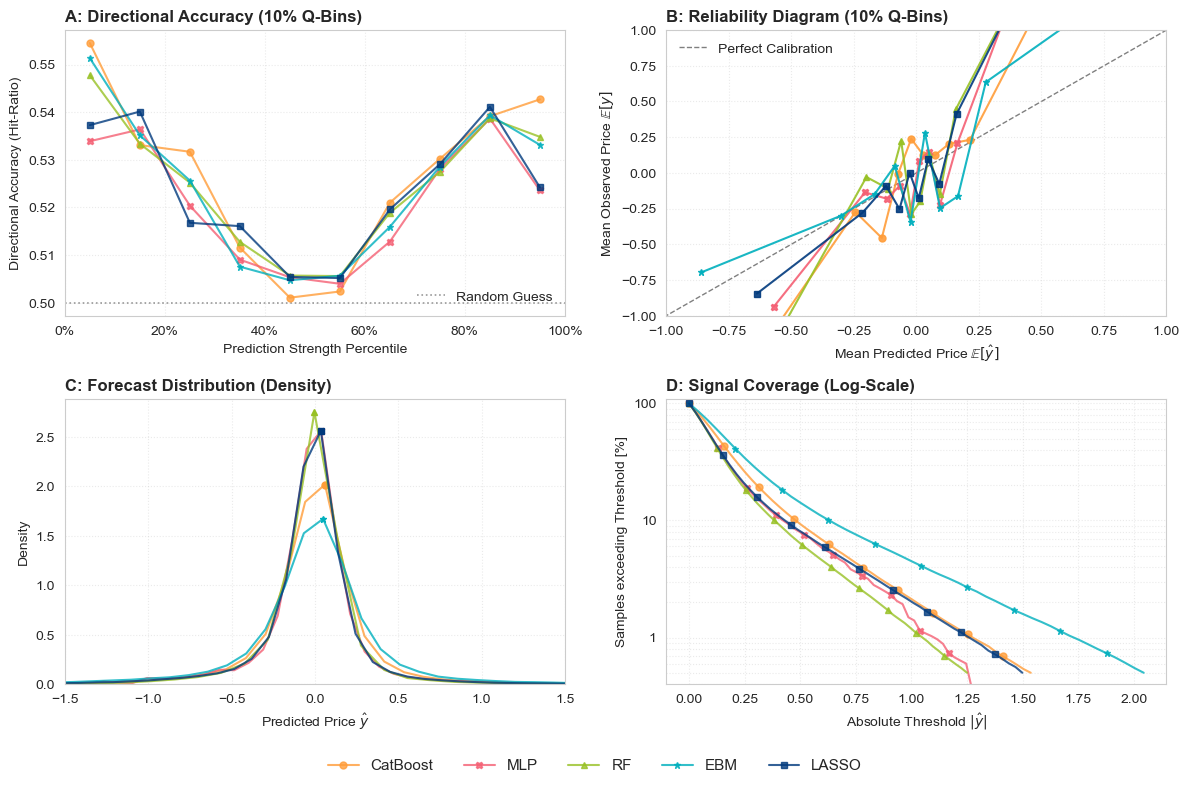

In [10]:
from src.d_eval.evaluation.predictive_performance import plot_reliability_density

plot_reliability_density(
    preds_raw, y_test_raw,
    bin_step_rel=0.1,
    bin_step_acc=0.10,
    save_name="reliability_density.png",
    limits_A_acc=None,  # Limits für Accuracy (A)
    limits_B_cal=[(-1, 1), (-1, 1)],  # Limits für Reliability (B)
    limits_C_dens=[(-1.5, 1.5), None],
    limits_D_cov=[None, (0.4, 110)],
)

/Users/robin/PycharmProjects/Masterarbeit_Public/src/d_eval/evaluation/predictive_performance.py:581: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Grafik gespeichert in: figures/pred/test_regime_analysis.png


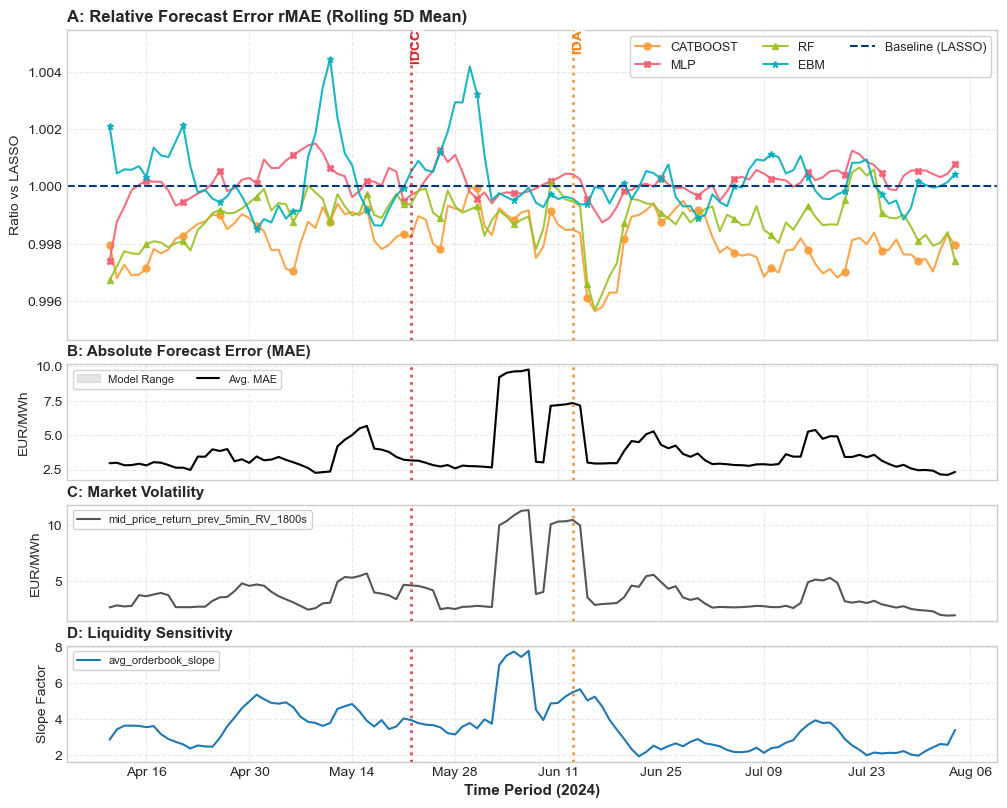

In [11]:
from src.d_eval.evaluation.predictive_performance import test_regime_analysis

# Ausführen
test_regime_analysis(
    preds_raw, y_test_raw, X_test_raw, snapshot_times,
    rolling_window=5, save_name="test_regime_analysis.png"
)

✅ Grafik gespeichert in: figures/pred/lifecycle_regime_analysis.png


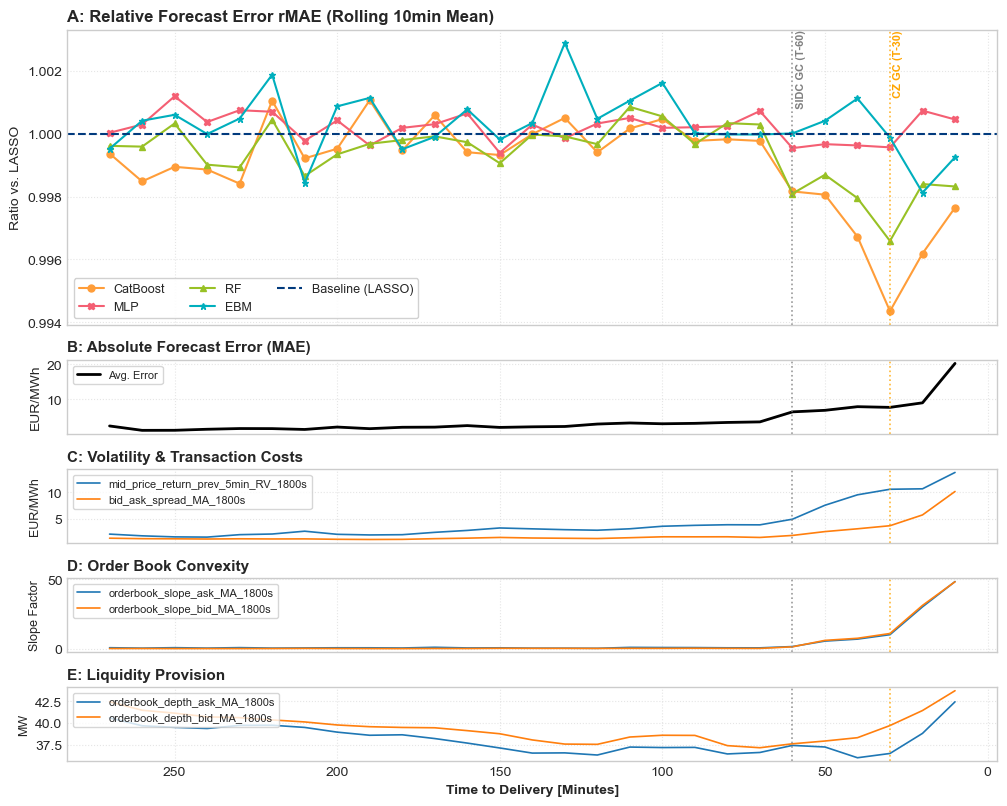

In [12]:
from src.d_eval.evaluation.predictive_performance import lifecycle_regime_analysis

config = {
    "Volatility & Transaction Costs": {
        "cols": ["mid_price_return_prev_5min_RV_1800s", "bid_ask_spread_MA_1800s"],
        "unit": "EUR/MWh"
    },
    "Order Book Convexity": {
        "cols": ["orderbook_slope_ask_MA_1800s", "orderbook_slope_bid_MA_1800s"],
        "unit": "Slope Factor"
    },
    "Liquidity Provision": {
        "cols": ["orderbook_depth_ask_MA_1800s", "orderbook_depth_bid_MA_1800s"],
        "unit": "MW"
    }
}

# Aufruf
lifecycle_regime_analysis(
    predictions_raw=preds_raw,
    y_true_raw=y_test_raw,
    X_test_raw=X_test_raw,
    feature_config=config,
    ttd_series=ttd_min,
    baseline_name="LASSO",
    bin_step=10,
    save_name="lifecycle_regime_analysis.png"
)

# Regime Analysis

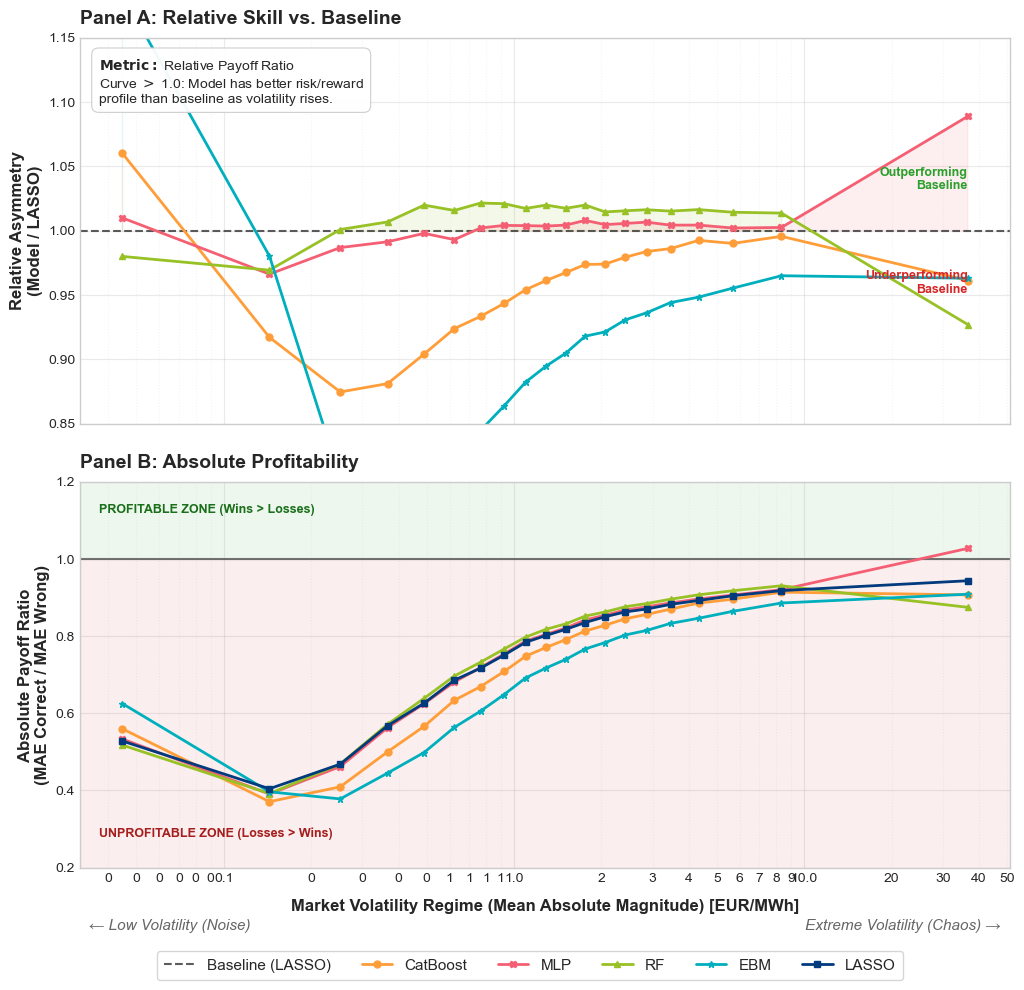

In [13]:
from src.d_eval.evaluation.predictive_performance import plot_payoff_analysis

plot_payoff_analysis(preds_raw, y_test_raw, baseline_name='LASSO', n_quantiles=20)

# robustness analysis

rMAE Robustness: 100%|██████████| 18/18 [00:06<00:00,  2.69it/s]


✅ Grafik gespeichert in: figures/pred/regression_robustness_analysis_rmae_part_1.png


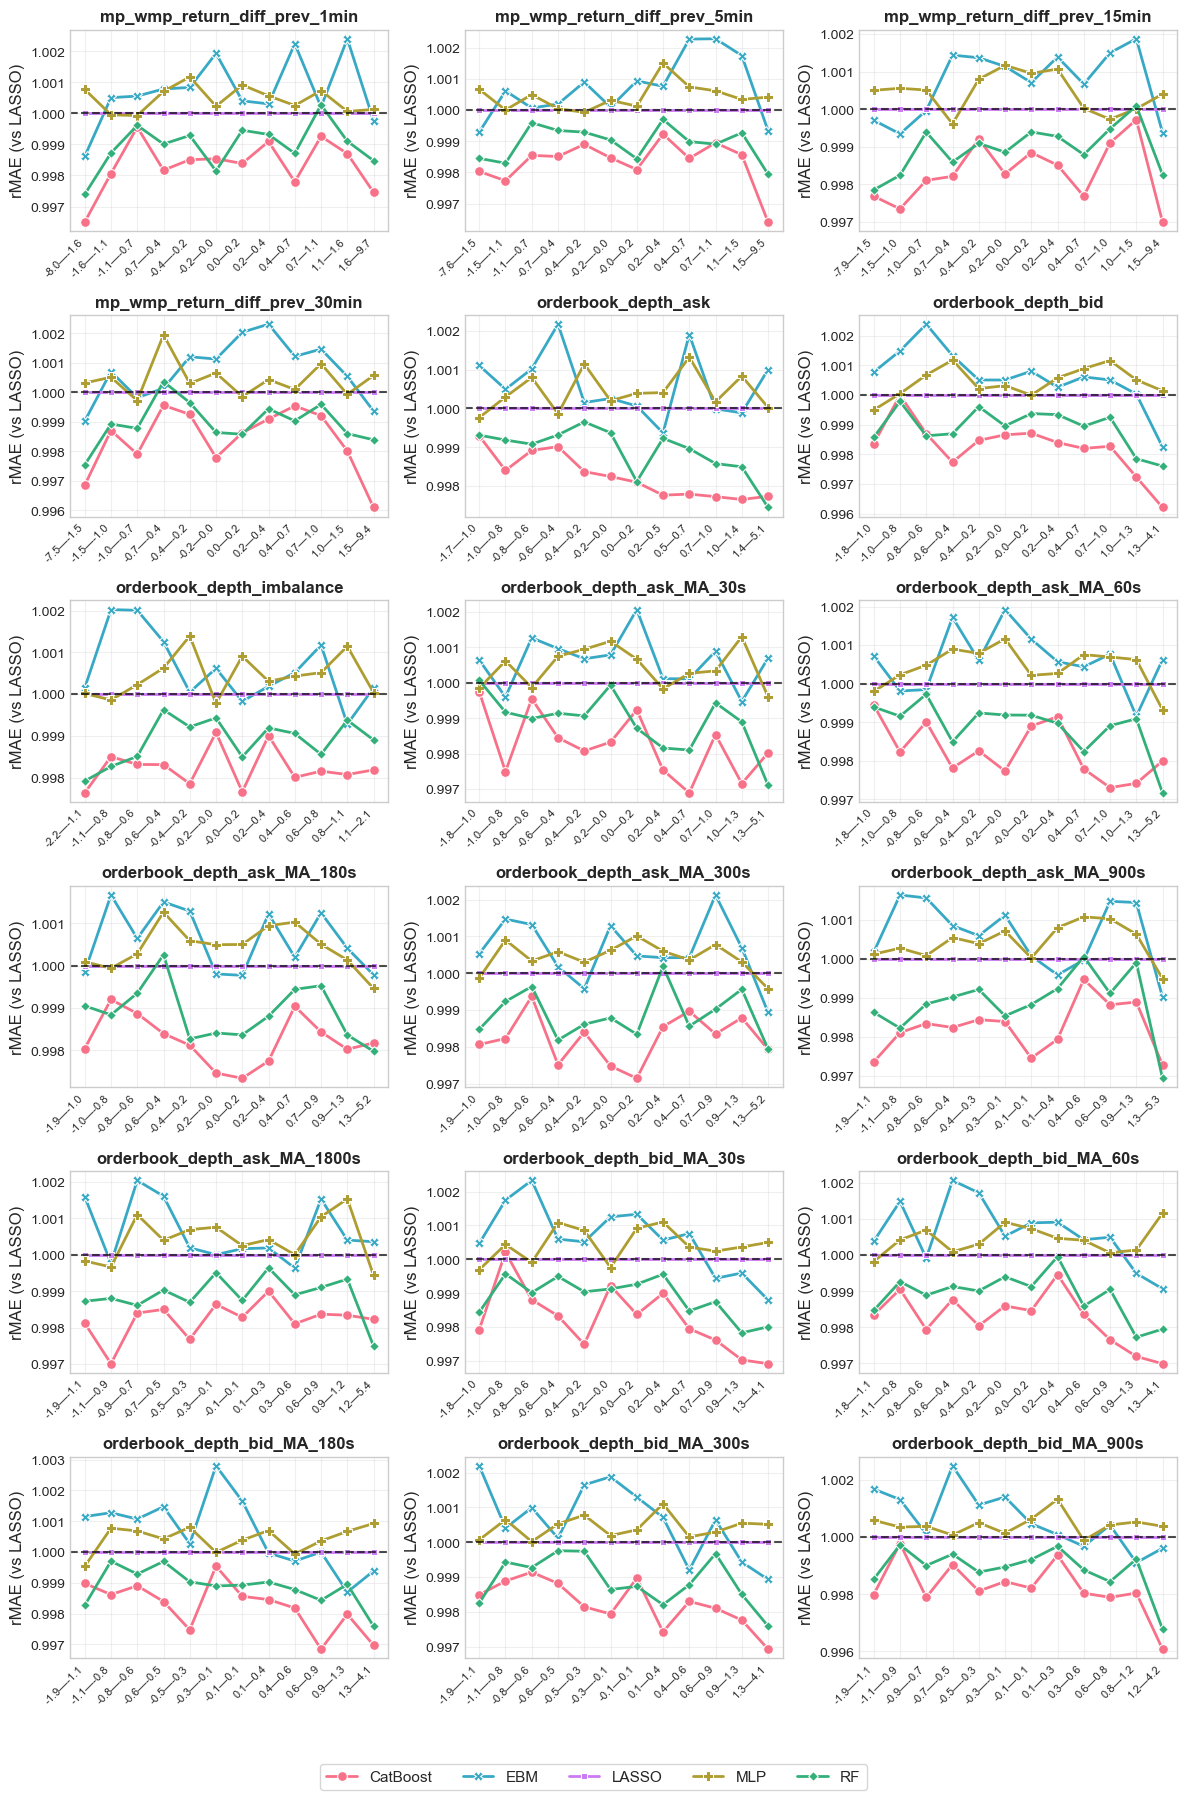

rMAE Robustness: 100%|██████████| 18/18 [00:05<00:00,  3.09it/s]


✅ Grafik gespeichert in: figures/pred/regression_robustness_analysis_rmae_part_2.png


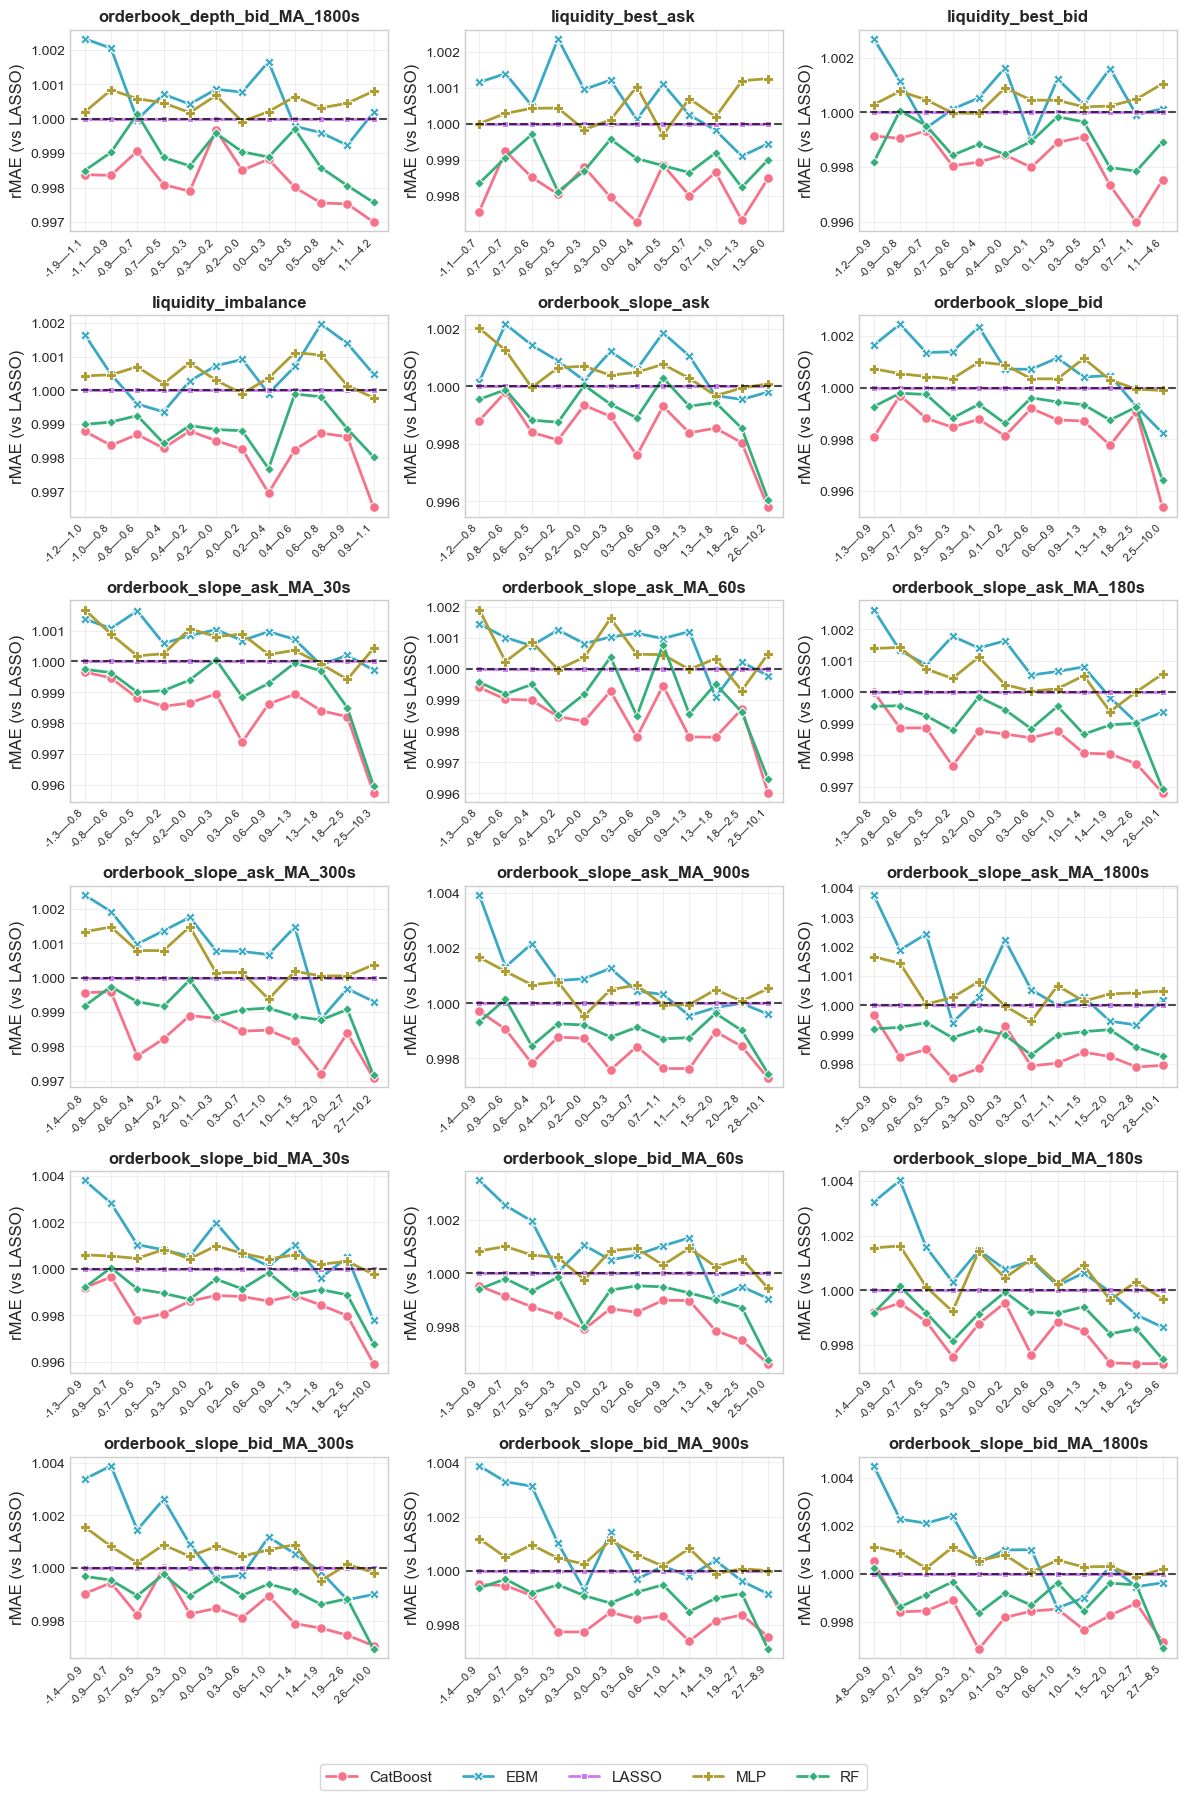

rMAE Robustness: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s]


✅ Grafik gespeichert in: figures/pred/regression_robustness_analysis_rmae_part_3.png


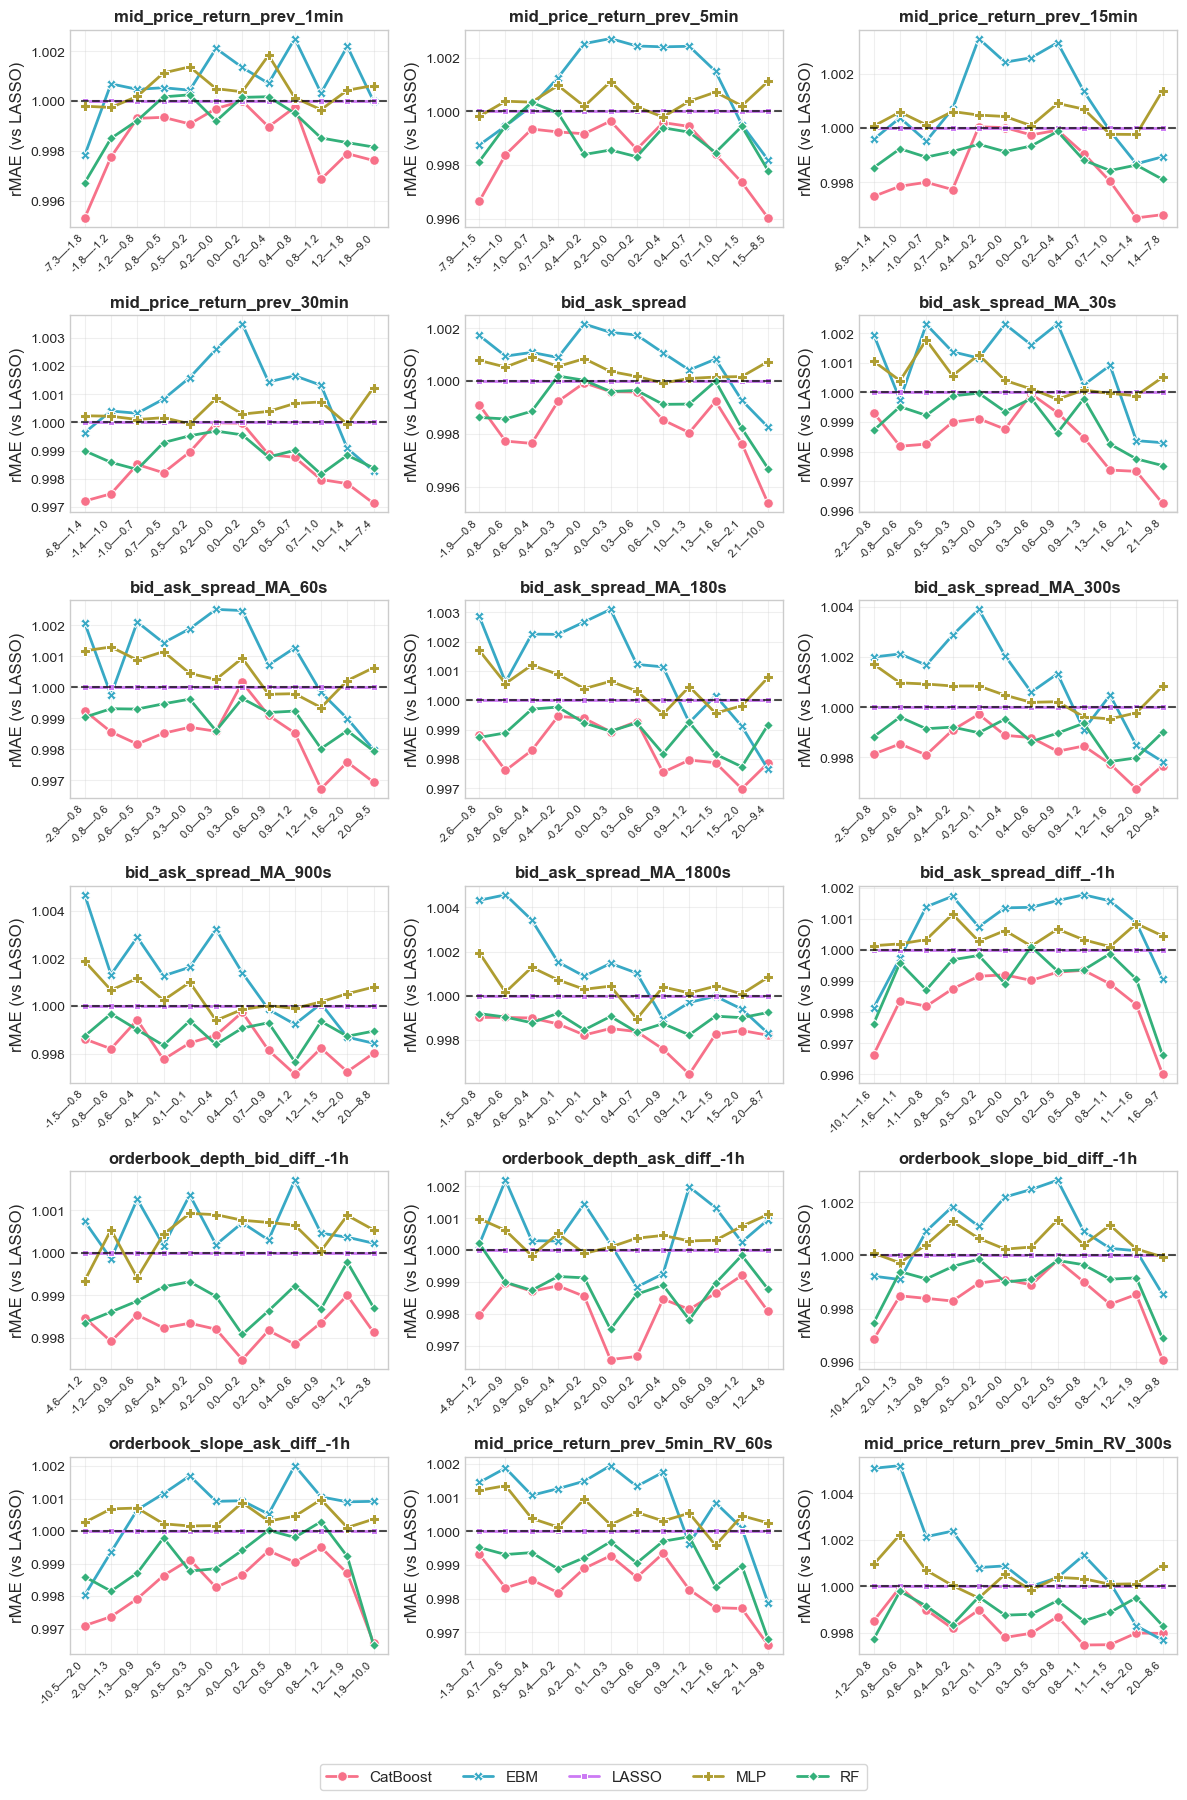

rMAE Robustness: 100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


✅ Grafik gespeichert in: figures/pred/regression_robustness_analysis_rmae_part_4.png


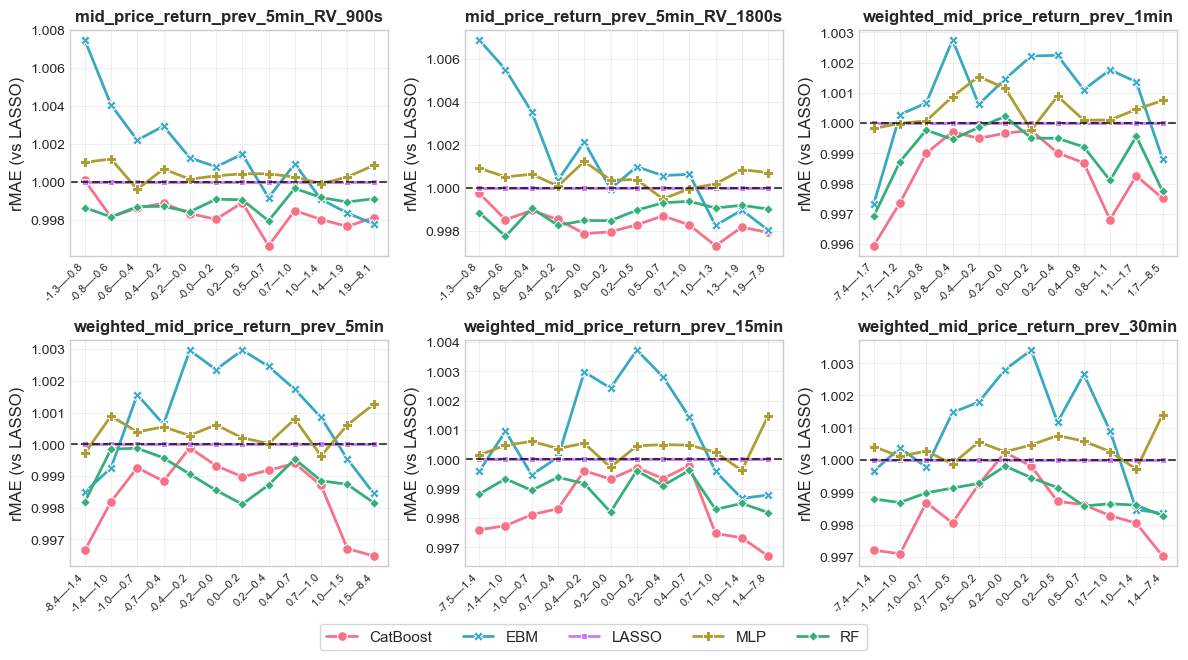

In [14]:
from src.d_eval.evaluation.predictive_performance import plot_dynamic_regression_rmae_robustness

# all features
cols_to_plot = [col for col in X_test_scaled.columns.tolist() if col not in ["delivery_start", "snapshot_times"]]

# filter for "te_" and "pn_" features
cols_to_plot = [col for col in cols_to_plot if
                not col.startswith("te_") and not col.startswith("pn_") and not col.startswith("time_")]

# split features into groups of size

n_plots_per_page = 18

for i in range(0, len(cols_to_plot), n_plots_per_page):
    subset_cols = cols_to_plot[i:i + n_plots_per_page]
    plot_dynamic_regression_rmae_robustness(
        predictions=preds_scaled,
        y_true=y_test_scaled,
        df_metadata=X_test_scaled,
        features_to_analyze=subset_cols,
        n_bins_quantile=12,
        n_cols=3,
        save_name=f"regression_robustness_analysis_rmae_part_{i // n_plots_per_page + 1}.png",
        baseline_name="LASSO"
    )
